# LSTM - vanilla

In [1]:
# best_model = "best_model0.pt"
best_model = "best_model0_feat_eng.pt"

## Load and prepare data

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

In [7]:
train_file = np.load('../cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('../cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


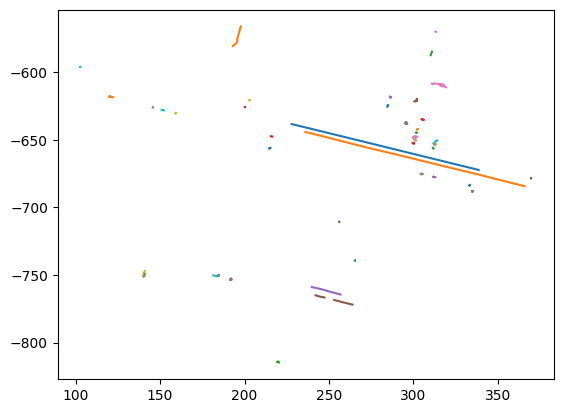

In [4]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

# Data Loaders

In [4]:
# class TrajectoryDatasetTrain(Dataset):
#     def __init__(self, data, scale=10.0, augment=True):
#         """
#         data: Shape (N, 50, 110, 6) Training data
#         scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
#         augment: Whether to apply data augmentation (only for training)
#         """
#         self.data = data
#         self.scale = scale
#         self.augment = augment

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         scene = self.data[idx]
#         # Getting 50 historical timestamps and 60 future timestamps
#         hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
#         future = torch.tensor(scene[0, 50:, 2:4].copy(), dtype=torch.float32)  # (60, 2)
        
#         # Data augmentation(only for training)
#         if self.augment:
#             if np.random.rand() < 0.5:
#                 theta = np.random.uniform(-np.pi, np.pi)
#                 R = np.array([[np.cos(theta), -np.sin(theta)],
#                               [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
#                 # Rotate the historical trajectory and future trajectory
#                 hist[..., :2] = hist[..., :2] @ R
#                 hist[..., 2:4] = hist[..., 2:4] @ R
#                 future = future @ R
#             if np.random.rand() < 0.5:
#                 hist[..., 0] *= -1
#                 hist[..., 2] *= -1
#                 future[:, 0] *= -1

#         # Use the last timeframe of the historical trajectory as the origin
#         origin = hist[0, 49, :2].copy()  # (2,)
#         hist[..., :2] = hist[..., :2] - origin
#         # future = future - origin

#         # Normalize the historical trajectory and future trajectory
#         hist[..., :4] = hist[..., :4] / self.scale
#         future = future / self.scale

#         data_item = Data(
#             x=torch.tensor(hist, dtype=torch.float32),
#             y=future.type(torch.float32),
#             origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0), # (1,2)
#             scale=torch.tensor(self.scale, dtype=torch.float32), # scalar e.g. 7.0
#         )
        
#         # print(f'x: {data_item.x.shape}')
#         # print(f'y: {data_item.y.shape}')

#         return data_item
    

# class TrajectoryDatasetTest(Dataset):
#     def __init__(self, data, scale=10.0):
#         """
#         data: Shape (N, 50, 110, 6) Testing data
#         scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
#         """
#         self.data = data
#         self.scale = scale

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         # Testing data only contains historical trajectory
#         scene = self.data[idx]  # (50, 50, 6)
#         hist = scene.copy()
        
#         origin = hist[0, 49, :2].copy()
#         hist[..., :2] = hist[..., :2] - origin
#         hist[..., :4] = hist[..., :4] / self.scale

#         data_item = Data(
#             x=torch.tensor(hist, dtype=torch.float32),
#             origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
#             scale=torch.tensor(self.scale, dtype=torch.float32),
#         )
#         return data_item

In [13]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        self.data = data
        self.scale = scale
        self.augment = augment
        self.dt = 0.1  # seconds

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        hist = scene[:, :50, :4].copy()  # (agents=50, time_seq=50, 5)
        future = torch.tensor(scene[0, 50:, 0:4].copy(), dtype=torch.float32)  # (60, 2)

        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future[..., :2] = future[..., :2] @ R
                future[..., 2:4] = future[..., 2:4] @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1
                future[:, 2] *= -1

        # Compute acceleration and angular velocity
        v = hist[..., 2:4]  # velocity
        a = np.zeros_like(v)
        a[..., 1:] = (v[..., 1:] - v[..., :-1]) / self.dt

        theta = np.arctan2(v[..., 1], v[..., 0])
        theta = theta[..., np.newaxis]
        omega = np.zeros_like(theta)
        omega[..., 1:] = (theta[..., 1:] - theta[..., :-1]) / self.dt
        # omega = omega[..., np.newaxis]  # shape: (50, 50, 1)

        hist_aug = np.concatenate([hist, a, theta, omega], axis=-1)  # shape: (50, 50, 8)

        # Coordinate transform and normalization
        origin = hist_aug[0, 49, :2].copy()
        hist_aug[..., :2] -= origin
        hist_aug[..., :4] /= self.scale  # x, y, vx, vy
        hist_aug[..., 4:6] /= self.scale / self.dt  # ax, ay
        hist_aug[..., 6] /= np.pi  # normalize theta
        hist_aug[..., 7] /= (np.pi / self.dt)  # normalize angular velocity ~ [-10, 10]
        future[..., :2] = future[..., :2] - origin
        future = future / self.scale
        
        # print(f'dataset Data.x: {hist_aug.shape}')
        # print(f'dataset Data.y: {future.shape}')

        return Data(
            x=torch.tensor(hist_aug, dtype=torch.float32),
            y=future,
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        
class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        self.data = data
        self.scale = scale
        self.dt = 0.1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        hist = self.data[idx][:, :50, :4].copy()  # (50, 50, 6)

        v = hist[..., 2:4]
        a = np.zeros_like(v)
        a[..., 1:] = (v[..., 1:] - v[..., :-1]) / self.dt

        theta = np.arctan2(v[..., 1], v[..., 0])
        theta = theta[..., np.newaxis]
        omega = np.zeros_like(theta)
        omega[..., 1:] = (theta[..., 1:] - theta[..., :-1]) / self.dt
        # omega = omega[..., np.newaxis]

        hist_aug = np.concatenate([hist, a, theta, omega], axis=-1)

        origin = hist_aug[0, 49, :2].copy()
        hist_aug[..., :2] -= origin
        hist_aug[..., :4] /= self.scale
        hist_aug[..., 4:6] /= self.scale / self.dt
        hist_aug[..., 6] /= np.pi  # normalize theta
        hist_aug[..., 7] /= (np.pi / self.dt)  # normalize angular velocity ~ [-10, 10]

        return Data(
            x=torch.tensor(hist_aug, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )



In [14]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


# LSTM

In [15]:
# Example of basic model that should work
class SimpleLSTM(nn.Module):
    # 2 layers 9.77 val
    def __init__(self, input_dim=8, hidden_dim=512, output_dim=60*2, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.ego_encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.neighbor_encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        
        # Add multi-layer prediction head for better results
        self.fc1 = nn.Linear(hidden_dim*2, hidden_dim*2)
        # TODO: remove dropout?
        self.dropout = nn.Dropout(0.1)  # Add dropout for regularization
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim*2, output_dim)
        
        self.input_dim = input_dim
        
        # Initialize weights properly
        # for name, param in self.named_parameters():
        #     if 'weight' in name:
        #         nn.init.xavier_normal_(param)
        #     elif 'bias' in name:
        #         nn.init.constant_(param, 0.0)
        
    def forward(self, data):
        # x = data.x[..., :5]
        x = data.x.reshape(-1, 50, 50, self.input_dim)  # (batch_size, num_agents, seq_len, input_dim)
        batch_size = x.size(0)
        # x = x[:, 0, :, :]  # Only consider ego agent (index 0)
        
        # EGO AGENT
        ego_traj = x[:, 0, :, :]  # (batch, 50, 5)
        # Process through LSTM
        ego_lstm_out, _ = self.ego_encoder(ego_traj)
        # Extract final hidden state
        ego_features = ego_lstm_out[:, -1, :]
        
        # CLOSEST NEIGHBOR
        # ---- DISTANCES TO OTHER AGENTS ----
        ego_pos = x[:, 0, 49, :2].unsqueeze(1)  # (batch, 1, 2)
        agent_pos = x[:, :, 49, :2]  # (batch, 50, 2)
        dists = torch.norm(agent_pos - ego_pos, dim=-1)  # (batch, 50)
        dists[:, 0] = float('inf')  # mask out ego
        
        _, neighbor_ids = torch.topk(dists, k=1, dim=1, largest=False)  # (batch, 3)
        
        # ---- ENCODE NEIGHBORS ----
        neighbor_out_list = []

        for i in range(1):
            idx = neighbor_ids[:, i]  # (batch,)
            neighbor_trajs = torch.stack([x[b, idx[b]] for b in range(batch_size)], dim=0)  # (batch, 50, 5)

            neighbor_lstm_out, _ = self.neighbor_encoder(neighbor_trajs)  # both: (num_layers, batch, hidden_dim)

            neighbor_out_list.append(neighbor_lstm_out[:, -1, :])

        # ---- CONCATENATE HIDDEN AND CELL STATES ----
        all_features = torch.cat([ego_features] + neighbor_out_list, dim=1)  # (num_layers, batch, hidden_dim * 4)
        
        # Process through prediction head
        features = self.relu(self.fc1(all_features))
        features = self.dropout(features)
        out = self.fc2(features)
        
        # Reshape to (batch_size, 60, 2)
        return out.view(-1, 60, 2)

# Train

In [62]:
def train_improved_model(model, train_dataloader, val_dataloader, 
                         device, criterion=nn.MSELoss(), 
                         lr=0.001, epochs=100, patience=15):
    """
    Improved training function with better debugging and early stopping
    """
    # Initialize optimizer with smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Exponential decay scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    early_stopping_patience = patience
    best_val_loss = float('inf')
    no_improvement = 0
    
    # Save initial state for comparison
    initial_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
    
    for epoch in tqdm.tqdm(range(epochs), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        num_train_batches = 0
        
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Check for NaN predictions
            if torch.isnan(pred).any():
                print(f"WARNING: NaN detected in predictions during training")
                continue
                
            loss = criterion(pred, y)
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Invalid loss value: {loss.item()}")
                continue
                
            optimizer.zero_grad()
            loss.backward()
            
            # More conservative gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1
        
        # Skip epoch if no valid batches
        if num_train_batches == 0:
            print("WARNING: No valid training batches in this epoch")
            continue
            
        train_loss /= num_train_batches
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        num_val_batches = 0
        
        # Sample predictions for debugging
        sample_input = None
        sample_pred = None
        sample_target = None
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                
                # Store sample for debugging
                if batch_idx == 0 and sample_input is None:
                    sample_input = batch.x[0].cpu().numpy()
                    sample_pred = pred[0].cpu().numpy()
                    sample_target = y[0].cpu().numpy()
                
                # Skip invalid predictions
                if torch.isnan(pred).any():
                    print(f"WARNING: NaN detected in predictions during validation")
                    continue
                    
                batch_loss = criterion(pred, y).item()
                val_loss += batch_loss
                
                # Unnormalize for real-world metrics
                pred_unnorm = pred * batch.scale.view(-1, 1, 1)
                y_unnorm = y * batch.scale.view(-1, 1, 1)
                
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
                
                num_val_batches += 1
        
        # Skip epoch if no valid validation batches
        if num_val_batches == 0:
            print("WARNING: No valid validation batches in this epoch")
            continue
            
        val_loss /= num_val_batches
        val_mae /= num_val_batches
        val_mse /= num_val_batches
        
        # Update learning rate
        scheduler.step()
        
        # Print with more details
        tqdm.tqdm.write(
            f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
            f"Train MSE {train_loss:.4f} | Val MSE {val_loss:.4f} | "
            f"Val MAE {val_mae:.4f} | Val MSE {val_mse:.4f}"
        )
        
        # Debug output - first 3 predictions vs targets
        if epoch % 5 == 0:
            tqdm.tqdm.write(f"Sample pred first 3 steps: {sample_pred[:3]}")
            tqdm.tqdm.write(f"Sample target first 3 steps: {sample_target[:3]}")
            
            # Check if model weights are changing
            if epoch > 0:
                weight_change = False
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        initial_param = initial_state_dict[name]
                        if not torch.allclose(param, initial_param, rtol=1e-4):
                            weight_change = True
                            break
                if not weight_change:
                    tqdm.tqdm.write("WARNING: Model weights barely changing!")
        
        # Relaxed improvement criterion - consider any improvement
        if val_loss < best_val_loss:
            tqdm.tqdm.write(f"Validation improved: {best_val_loss:.6f} -> {val_loss:.6f}")
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), best_model)
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs without improvement")
                break
    
    # Load best model before returning
    model.load_state_dict(torch.load(best_model))
    return model

In [63]:
# Example usage
def train_and_evaluate_model():
    # Create model
    model = SimpleLSTM()
    model = model.to(device)
    
    # Train with improved function
    train_improved_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        # lr = 0.007 => 8.946
        lr=0.005,  # Lower learning rate
        patience=20,  # More patience
        epochs=150
    )
    
    # Evaluate
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Unnormalize
            pred = pred * batch.scale.view(-1, 1, 1)
            y = y * batch.scale.view(-1, 1, 1)
            
            test_mse += nn.MSELoss()(pred, y).item()
    
    test_mse /= len(val_dataloader)
    print(f"Val MSE: {test_mse:.4f}")
    
    return model

# Train execute

In [64]:
# ax, ay, ang vel

train_and_evaluate_model()

Epoch:   0%|          | 0/150 [00:00<?, ?epoch/s]/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_46909/4211916913.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
Epoch:   1%|          | 1/150 [00:11<29:13, 11.77s/epoch]

Epoch 000 | LR 0.004750 | Train MSE 0.1519 | Val MSE 0.0683 | Val MAE 1.1959 | Val MSE 3.3460
Sample pred first 3 steps: [[-0.01465892  0.09872176]
 [-0.00534683  0.09281453]
 [-0.01269742  0.09460756]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: inf -> 0.068287


Epoch:   1%|▏         | 2/150 [00:23<28:33, 11.58s/epoch]

Epoch 001 | LR 0.004513 | Train MSE 0.0700 | Val MSE 0.0671 | Val MAE 1.1772 | Val MSE 3.2903
Validation improved: 0.068287 -> 0.067149


Epoch:   2%|▏         | 3/150 [00:34<27:50, 11.36s/epoch]

Epoch 002 | LR 0.004287 | Train MSE 0.0680 | Val MSE 0.0693 | Val MAE 1.2246 | Val MSE 3.3951


Epoch:   3%|▎         | 4/150 [00:45<27:18, 11.22s/epoch]

Epoch 003 | LR 0.004073 | Train MSE 0.0673 | Val MSE 0.0704 | Val MAE 1.2414 | Val MSE 3.4482


Epoch:   3%|▎         | 5/150 [00:56<27:25, 11.35s/epoch]

Epoch 004 | LR 0.003869 | Train MSE 0.0666 | Val MSE 0.0668 | Val MAE 1.1961 | Val MSE 3.2715
Validation improved: 0.067149 -> 0.066765


Epoch:   4%|▍         | 6/150 [01:08<27:09, 11.31s/epoch]

Epoch 005 | LR 0.003675 | Train MSE 0.0658 | Val MSE 0.0578 | Val MAE 1.0143 | Val MSE 2.8327
Sample pred first 3 steps: [[-0.03502442 -0.01827479]
 [-0.03655275 -0.01649903]
 [-0.03576453 -0.01696312]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.066765 -> 0.057809


Epoch:   5%|▍         | 7/150 [01:19<27:05, 11.37s/epoch]

Epoch 006 | LR 0.003492 | Train MSE 0.0640 | Val MSE 0.0591 | Val MAE 1.0289 | Val MSE 2.8953


Epoch:   5%|▌         | 8/150 [01:31<27:03, 11.44s/epoch]

Epoch 007 | LR 0.003317 | Train MSE 0.0614 | Val MSE 0.0558 | Val MAE 1.0333 | Val MSE 2.7356
Validation improved: 0.057809 -> 0.055828


Epoch:   6%|▌         | 9/150 [01:42<26:35, 11.31s/epoch]

Epoch 008 | LR 0.003151 | Train MSE 0.0583 | Val MSE 0.0501 | Val MAE 0.9751 | Val MSE 2.4571
Validation improved: 0.055828 -> 0.050144


Epoch:   7%|▋         | 10/150 [01:53<26:22, 11.31s/epoch]

Epoch 009 | LR 0.002994 | Train MSE 0.0558 | Val MSE 0.0488 | Val MAE 0.9388 | Val MSE 2.3930
Validation improved: 0.050144 -> 0.048836


Epoch:   7%|▋         | 11/150 [02:04<26:07, 11.28s/epoch]

Epoch 010 | LR 0.002844 | Train MSE 0.0537 | Val MSE 0.0474 | Val MAE 0.9195 | Val MSE 2.3214
Sample pred first 3 steps: [[ 0.00089839 -0.00764067]
 [ 0.00209126 -0.00759634]
 [ 0.00067211 -0.00700505]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.048836 -> 0.047375


Epoch:   8%|▊         | 12/150 [02:16<25:56, 11.28s/epoch]

Epoch 011 | LR 0.002702 | Train MSE 0.0524 | Val MSE 0.0471 | Val MAE 0.8992 | Val MSE 2.3070
Validation improved: 0.047375 -> 0.047081


Epoch:   9%|▊         | 13/150 [02:27<25:46, 11.29s/epoch]

Epoch 012 | LR 0.002567 | Train MSE 0.0495 | Val MSE 0.0443 | Val MAE 0.8894 | Val MSE 2.1716
Validation improved: 0.047081 -> 0.044319


Epoch:   9%|▉         | 14/150 [02:38<25:42, 11.34s/epoch]

Epoch 013 | LR 0.002438 | Train MSE 0.0507 | Val MSE 0.0449 | Val MAE 0.9038 | Val MSE 2.1996


Epoch:  10%|█         | 15/150 [02:50<25:35, 11.37s/epoch]

Epoch 014 | LR 0.002316 | Train MSE 0.0477 | Val MSE 0.0436 | Val MAE 0.8489 | Val MSE 2.1367
Validation improved: 0.044319 -> 0.043605


Epoch:  11%|█         | 16/150 [03:01<25:14, 11.30s/epoch]

Epoch 015 | LR 0.002201 | Train MSE 0.0468 | Val MSE 0.0410 | Val MAE 0.8161 | Val MSE 2.0106
Sample pred first 3 steps: [[0.0301517  0.00427836]
 [0.03059705 0.00370411]
 [0.03122761 0.00429806]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.043605 -> 0.041033


Epoch:  11%|█▏        | 17/150 [03:12<24:55, 11.24s/epoch]

Epoch 016 | LR 0.002091 | Train MSE 0.0450 | Val MSE 0.0411 | Val MAE 0.8340 | Val MSE 2.0146


Epoch:  12%|█▏        | 18/150 [03:23<24:40, 11.21s/epoch]

Epoch 017 | LR 0.001986 | Train MSE 0.0454 | Val MSE 0.0408 | Val MAE 0.8188 | Val MSE 1.9988
Validation improved: 0.041033 -> 0.040791


Epoch:  13%|█▎        | 19/150 [03:34<24:29, 11.22s/epoch]

Epoch 018 | LR 0.001887 | Train MSE 0.0444 | Val MSE 0.0418 | Val MAE 0.8354 | Val MSE 2.0471


Epoch:  13%|█▎        | 20/150 [03:47<25:09, 11.62s/epoch]

Epoch 019 | LR 0.001792 | Train MSE 0.0432 | Val MSE 0.0432 | Val MAE 0.8973 | Val MSE 2.1168


Epoch:  14%|█▍        | 21/150 [03:59<25:22, 11.80s/epoch]

Epoch 020 | LR 0.001703 | Train MSE 0.0431 | Val MSE 0.0394 | Val MAE 0.8096 | Val MSE 1.9284
Sample pred first 3 steps: [[0.02663188 0.01144589]
 [0.02767593 0.01502935]
 [0.02955691 0.01737935]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.040791 -> 0.039354


Epoch:  15%|█▍        | 22/150 [04:12<25:37, 12.01s/epoch]

Epoch 021 | LR 0.001618 | Train MSE 0.0427 | Val MSE 0.0397 | Val MAE 0.8018 | Val MSE 1.9431


Epoch:  15%|█▌        | 23/150 [04:23<24:49, 11.73s/epoch]

Epoch 022 | LR 0.001537 | Train MSE 0.0420 | Val MSE 0.0387 | Val MAE 0.7880 | Val MSE 1.8982
Validation improved: 0.039354 -> 0.038740


Epoch:  16%|█▌        | 24/150 [04:34<24:38, 11.74s/epoch]

Epoch 023 | LR 0.001460 | Train MSE 0.0418 | Val MSE 0.0406 | Val MAE 0.8162 | Val MSE 1.9876


Epoch:  17%|█▋        | 25/150 [04:47<24:44, 11.87s/epoch]

Epoch 024 | LR 0.001387 | Train MSE 0.0416 | Val MSE 0.0380 | Val MAE 0.7804 | Val MSE 1.8640
Validation improved: 0.038740 -> 0.038040


Epoch:  17%|█▋        | 26/150 [04:59<24:38, 11.93s/epoch]

Epoch 025 | LR 0.001318 | Train MSE 0.0410 | Val MSE 0.0398 | Val MAE 0.8136 | Val MSE 1.9521
Sample pred first 3 steps: [[0.0022368  0.00793702]
 [0.0029016  0.00871873]
 [0.00235926 0.00880712]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  18%|█▊        | 27/150 [05:10<24:14, 11.82s/epoch]

Epoch 026 | LR 0.001252 | Train MSE 0.0417 | Val MSE 0.0379 | Val MAE 0.7549 | Val MSE 1.8590
Validation improved: 0.038040 -> 0.037939


Epoch:  19%|█▊        | 28/150 [05:22<23:59, 11.80s/epoch]

Epoch 027 | LR 0.001189 | Train MSE 0.0406 | Val MSE 0.0406 | Val MAE 0.7766 | Val MSE 1.9889


Epoch:  19%|█▉        | 29/150 [05:33<23:31, 11.66s/epoch]

Epoch 028 | LR 0.001130 | Train MSE 0.0409 | Val MSE 0.0373 | Val MAE 0.7635 | Val MSE 1.8300
Validation improved: 0.037939 -> 0.037347


Epoch:  20%|██        | 30/150 [05:45<23:16, 11.64s/epoch]

Epoch 029 | LR 0.001073 | Train MSE 0.0406 | Val MSE 0.0382 | Val MAE 0.7956 | Val MSE 1.8696


Epoch:  21%|██        | 31/150 [05:58<23:44, 11.97s/epoch]

Epoch 030 | LR 0.001020 | Train MSE 0.0447 | Val MSE 0.0373 | Val MAE 0.7533 | Val MSE 1.8266
Sample pred first 3 steps: [[-0.00392676  0.01465975]
 [-0.00307066  0.01512546]
 [-0.00322838  0.01601382]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.037347 -> 0.037278


Epoch:  21%|██▏       | 32/150 [06:12<24:48, 12.62s/epoch]

Epoch 031 | LR 0.000969 | Train MSE 0.0400 | Val MSE 0.0382 | Val MAE 0.7641 | Val MSE 1.8718


Epoch:  22%|██▏       | 33/150 [06:26<25:27, 13.05s/epoch]

Epoch 032 | LR 0.000920 | Train MSE 0.0398 | Val MSE 0.0378 | Val MAE 0.7764 | Val MSE 1.8527


Epoch:  23%|██▎       | 34/150 [06:40<25:36, 13.25s/epoch]

Epoch 033 | LR 0.000874 | Train MSE 0.0396 | Val MSE 0.0371 | Val MAE 0.7572 | Val MSE 1.8202
Validation improved: 0.037278 -> 0.037147


Epoch:  23%|██▎       | 35/150 [06:54<26:18, 13.73s/epoch]

Epoch 034 | LR 0.000830 | Train MSE 0.0391 | Val MSE 0.0365 | Val MAE 0.7540 | Val MSE 1.7892
Validation improved: 0.037147 -> 0.036514


Epoch:  24%|██▍       | 36/150 [07:09<26:39, 14.03s/epoch]

Epoch 035 | LR 0.000789 | Train MSE 0.0390 | Val MSE 0.0367 | Val MAE 0.7399 | Val MSE 1.7998
Sample pred first 3 steps: [[-0.00075993  0.02356929]
 [-0.0004298   0.02282673]
 [ 0.00021977  0.02254897]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  25%|██▍       | 37/150 [07:23<26:16, 13.95s/epoch]

Epoch 036 | LR 0.000749 | Train MSE 0.0388 | Val MSE 0.0373 | Val MAE 0.7569 | Val MSE 1.8275


Epoch:  25%|██▌       | 38/150 [07:37<26:04, 13.96s/epoch]

Epoch 037 | LR 0.000712 | Train MSE 0.0382 | Val MSE 0.0379 | Val MAE 0.7542 | Val MSE 1.8559


Epoch:  26%|██▌       | 39/150 [07:51<25:42, 13.89s/epoch]

Epoch 038 | LR 0.000676 | Train MSE 0.0383 | Val MSE 0.0368 | Val MAE 0.7240 | Val MSE 1.8049


Epoch:  27%|██▋       | 40/150 [08:04<25:14, 13.77s/epoch]

Epoch 039 | LR 0.000643 | Train MSE 0.0381 | Val MSE 0.0380 | Val MAE 0.7537 | Val MSE 1.8601


Epoch:  27%|██▋       | 41/150 [08:19<25:41, 14.14s/epoch]

Epoch 040 | LR 0.000610 | Train MSE 0.0385 | Val MSE 0.0361 | Val MAE 0.7281 | Val MSE 1.7684
Sample pred first 3 steps: [[-0.00426797  0.00805147]
 [-0.00355303  0.00741466]
 [-0.00256801  0.00671038]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.036514 -> 0.036089


Epoch:  28%|██▊       | 42/150 [08:34<25:36, 14.23s/epoch]

Epoch 041 | LR 0.000580 | Train MSE 0.0375 | Val MSE 0.0367 | Val MAE 0.7395 | Val MSE 1.7972


Epoch:  29%|██▊       | 43/150 [08:48<25:25, 14.25s/epoch]

Epoch 042 | LR 0.000551 | Train MSE 0.0376 | Val MSE 0.0364 | Val MAE 0.7455 | Val MSE 1.7823


Epoch:  29%|██▉       | 44/150 [09:01<24:39, 13.96s/epoch]

Epoch 043 | LR 0.000523 | Train MSE 0.0373 | Val MSE 0.0367 | Val MAE 0.7458 | Val MSE 1.8001


Epoch:  30%|███       | 45/150 [09:15<24:07, 13.78s/epoch]

Epoch 044 | LR 0.000497 | Train MSE 0.0370 | Val MSE 0.0363 | Val MAE 0.7224 | Val MSE 1.7805


Epoch:  31%|███       | 46/150 [09:28<23:38, 13.64s/epoch]

Epoch 045 | LR 0.000472 | Train MSE 0.0370 | Val MSE 0.0359 | Val MAE 0.7314 | Val MSE 1.7575
Sample pred first 3 steps: [[-0.01779155  0.01264036]
 [-0.01745238  0.01163024]
 [-0.01545108  0.01091274]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.036089 -> 0.035867


Epoch:  31%|███▏      | 47/150 [09:41<23:05, 13.45s/epoch]

Epoch 046 | LR 0.000449 | Train MSE 0.0371 | Val MSE 0.0364 | Val MAE 0.7244 | Val MSE 1.7856


Epoch:  32%|███▏      | 48/150 [09:55<23:00, 13.53s/epoch]

Epoch 047 | LR 0.000426 | Train MSE 0.0369 | Val MSE 0.0373 | Val MAE 0.7774 | Val MSE 1.8263


Epoch:  33%|███▎      | 49/150 [10:08<22:45, 13.52s/epoch]

Epoch 048 | LR 0.000405 | Train MSE 0.0369 | Val MSE 0.0362 | Val MAE 0.7274 | Val MSE 1.7726


Epoch:  33%|███▎      | 50/150 [10:21<22:20, 13.41s/epoch]

Epoch 049 | LR 0.000385 | Train MSE 0.0365 | Val MSE 0.0357 | Val MAE 0.7212 | Val MSE 1.7469
Validation improved: 0.035867 -> 0.035650


Epoch:  34%|███▍      | 51/150 [10:34<22:00, 13.34s/epoch]

Epoch 050 | LR 0.000365 | Train MSE 0.0368 | Val MSE 0.0363 | Val MAE 0.7523 | Val MSE 1.7777
Sample pred first 3 steps: [[-0.0098056   0.01669595]
 [-0.00898128  0.01581857]
 [-0.00706008  0.01485515]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  35%|███▍      | 52/150 [10:48<21:46, 13.33s/epoch]

Epoch 051 | LR 0.000347 | Train MSE 0.0366 | Val MSE 0.0359 | Val MAE 0.7293 | Val MSE 1.7605


Epoch:  35%|███▌      | 53/150 [11:01<21:33, 13.33s/epoch]

Epoch 052 | LR 0.000330 | Train MSE 0.0363 | Val MSE 0.0356 | Val MAE 0.7208 | Val MSE 1.7437
Validation improved: 0.035650 -> 0.035586


Epoch:  36%|███▌      | 54/150 [11:15<21:29, 13.43s/epoch]

Epoch 053 | LR 0.000313 | Train MSE 0.0362 | Val MSE 0.0355 | Val MAE 0.7159 | Val MSE 1.7398
Validation improved: 0.035586 -> 0.035505


Epoch:  37%|███▋      | 55/150 [11:28<21:14, 13.42s/epoch]

Epoch 054 | LR 0.000298 | Train MSE 0.0359 | Val MSE 0.0362 | Val MAE 0.7243 | Val MSE 1.7736


Epoch:  37%|███▋      | 56/150 [11:41<20:54, 13.34s/epoch]

Epoch 055 | LR 0.000283 | Train MSE 0.0358 | Val MSE 0.0355 | Val MAE 0.7248 | Val MSE 1.7419
Sample pred first 3 steps: [[0.0032382  0.00125762]
 [0.00249634 0.00059718]
 [0.00237571 0.0004239 ]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  38%|███▊      | 57/150 [11:55<20:48, 13.43s/epoch]

Epoch 056 | LR 0.000269 | Train MSE 0.0361 | Val MSE 0.0354 | Val MAE 0.7109 | Val MSE 1.7322
Validation improved: 0.035505 -> 0.035352


Epoch:  39%|███▊      | 58/150 [12:08<20:30, 13.37s/epoch]

Epoch 057 | LR 0.000255 | Train MSE 0.0360 | Val MSE 0.0353 | Val MAE 0.7244 | Val MSE 1.7288
Validation improved: 0.035352 -> 0.035281


Epoch:  39%|███▉      | 59/150 [12:22<20:21, 13.43s/epoch]

Epoch 058 | LR 0.000242 | Train MSE 0.0356 | Val MSE 0.0353 | Val MAE 0.7100 | Val MSE 1.7273
Validation improved: 0.035281 -> 0.035251


Epoch:  40%|████      | 60/150 [12:35<20:13, 13.49s/epoch]

Epoch 059 | LR 0.000230 | Train MSE 0.0358 | Val MSE 0.0354 | Val MAE 0.7175 | Val MSE 1.7342


Epoch:  41%|████      | 61/150 [12:49<20:05, 13.54s/epoch]

Epoch 060 | LR 0.000219 | Train MSE 0.0355 | Val MSE 0.0355 | Val MAE 0.7143 | Val MSE 1.7410
Sample pred first 3 steps: [[-0.01171254 -0.00673851]
 [-0.01150326 -0.00708376]
 [-0.01046128 -0.00744118]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  41%|████▏     | 62/150 [13:02<19:40, 13.42s/epoch]

Epoch 061 | LR 0.000208 | Train MSE 0.0356 | Val MSE 0.0354 | Val MAE 0.7187 | Val MSE 1.7356


Epoch:  42%|████▏     | 63/150 [13:16<19:36, 13.53s/epoch]

Epoch 062 | LR 0.000197 | Train MSE 0.0353 | Val MSE 0.0351 | Val MAE 0.7039 | Val MSE 1.7198
Validation improved: 0.035251 -> 0.035098


Epoch:  43%|████▎     | 64/150 [13:29<19:21, 13.50s/epoch]

Epoch 063 | LR 0.000188 | Train MSE 0.0353 | Val MSE 0.0350 | Val MAE 0.7107 | Val MSE 1.7165
Validation improved: 0.035098 -> 0.035030


Epoch:  43%|████▎     | 65/150 [13:43<18:58, 13.39s/epoch]

Epoch 064 | LR 0.000178 | Train MSE 0.0355 | Val MSE 0.0355 | Val MAE 0.7161 | Val MSE 1.7401


Epoch:  44%|████▍     | 66/150 [13:56<18:49, 13.45s/epoch]

Epoch 065 | LR 0.000169 | Train MSE 0.0353 | Val MSE 0.0352 | Val MAE 0.7089 | Val MSE 1.7241
Sample pred first 3 steps: [[-0.01133558 -0.01160515]
 [-0.01069045 -0.01154024]
 [-0.0093985  -0.0110203 ]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  45%|████▍     | 67/150 [14:10<18:49, 13.61s/epoch]

Epoch 066 | LR 0.000161 | Train MSE 0.0349 | Val MSE 0.0351 | Val MAE 0.7049 | Val MSE 1.7200


Epoch:  45%|████▌     | 68/150 [14:24<18:40, 13.67s/epoch]

Epoch 067 | LR 0.000153 | Train MSE 0.0354 | Val MSE 0.0353 | Val MAE 0.7167 | Val MSE 1.7295


Epoch:  46%|████▌     | 69/150 [14:37<18:23, 13.62s/epoch]

Epoch 068 | LR 0.000145 | Train MSE 0.0351 | Val MSE 0.0351 | Val MAE 0.7097 | Val MSE 1.7213


Epoch:  47%|████▋     | 70/150 [14:51<17:58, 13.49s/epoch]

Epoch 069 | LR 0.000138 | Train MSE 0.0350 | Val MSE 0.0353 | Val MAE 0.7195 | Val MSE 1.7300


Epoch:  47%|████▋     | 71/150 [15:03<17:32, 13.32s/epoch]

Epoch 070 | LR 0.000131 | Train MSE 0.0351 | Val MSE 0.0350 | Val MAE 0.7003 | Val MSE 1.7167
Sample pred first 3 steps: [[-0.00600217 -0.01015676]
 [-0.00555294 -0.00986825]
 [-0.00475537 -0.00943905]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  48%|████▊     | 72/150 [15:17<17:17, 13.30s/epoch]

Epoch 071 | LR 0.000124 | Train MSE 0.0349 | Val MSE 0.0350 | Val MAE 0.7029 | Val MSE 1.7152
Validation improved: 0.035030 -> 0.035005


Epoch:  49%|████▊     | 73/150 [15:30<17:01, 13.27s/epoch]

Epoch 072 | LR 0.000118 | Train MSE 0.0349 | Val MSE 0.0352 | Val MAE 0.7058 | Val MSE 1.7230


Epoch:  49%|████▉     | 74/150 [15:43<16:46, 13.25s/epoch]

Epoch 073 | LR 0.000112 | Train MSE 0.0348 | Val MSE 0.0350 | Val MAE 0.7038 | Val MSE 1.7127
Validation improved: 0.035005 -> 0.034953


Epoch:  50%|█████     | 75/150 [15:57<16:41, 13.35s/epoch]

Epoch 074 | LR 0.000107 | Train MSE 0.0351 | Val MSE 0.0347 | Val MAE 0.7013 | Val MSE 1.7013
Validation improved: 0.034953 -> 0.034720


Epoch:  51%|█████     | 76/150 [16:10<16:28, 13.36s/epoch]

Epoch 075 | LR 0.000101 | Train MSE 0.0346 | Val MSE 0.0348 | Val MAE 0.6982 | Val MSE 1.7045
Sample pred first 3 steps: [[-0.00420634 -0.00454657]
 [-0.00397827 -0.00438734]
 [-0.00349451 -0.0042087 ]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  51%|█████▏    | 77/150 [16:23<16:09, 13.28s/epoch]

Epoch 076 | LR 0.000096 | Train MSE 0.0347 | Val MSE 0.0348 | Val MAE 0.7040 | Val MSE 1.7030


Epoch:  52%|█████▏    | 78/150 [16:37<15:58, 13.31s/epoch]

Epoch 077 | LR 0.000091 | Train MSE 0.0345 | Val MSE 0.0350 | Val MAE 0.7151 | Val MSE 1.7129


Epoch:  53%|█████▎    | 79/150 [16:50<15:48, 13.36s/epoch]

Epoch 078 | LR 0.000087 | Train MSE 0.0347 | Val MSE 0.0348 | Val MAE 0.7045 | Val MSE 1.7061


Epoch:  53%|█████▎    | 80/150 [17:04<15:43, 13.48s/epoch]

Epoch 079 | LR 0.000083 | Train MSE 0.0345 | Val MSE 0.0348 | Val MAE 0.7062 | Val MSE 1.7051


Epoch:  54%|█████▍    | 81/150 [17:18<15:44, 13.69s/epoch]

Epoch 080 | LR 0.000078 | Train MSE 0.0345 | Val MSE 0.0347 | Val MAE 0.7042 | Val MSE 1.6995
Sample pred first 3 steps: [[-0.00286053 -0.00352262]
 [-0.00274412 -0.00342513]
 [-0.00210393 -0.00270044]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.034720 -> 0.034685


Epoch:  55%|█████▍    | 82/150 [17:32<15:34, 13.74s/epoch]

Epoch 081 | LR 0.000075 | Train MSE 0.0345 | Val MSE 0.0348 | Val MAE 0.7094 | Val MSE 1.7031


Epoch:  55%|█████▌    | 83/150 [17:46<15:25, 13.81s/epoch]

Epoch 082 | LR 0.000071 | Train MSE 0.0344 | Val MSE 0.0345 | Val MAE 0.6985 | Val MSE 1.6914
Validation improved: 0.034685 -> 0.034518


Epoch:  56%|█████▌    | 84/150 [17:59<14:59, 13.63s/epoch]

Epoch 083 | LR 0.000067 | Train MSE 0.0342 | Val MSE 0.0349 | Val MAE 0.7011 | Val MSE 1.7077


Epoch:  57%|█████▋    | 85/150 [18:12<14:31, 13.41s/epoch]

Epoch 084 | LR 0.000064 | Train MSE 0.0344 | Val MSE 0.0348 | Val MAE 0.7008 | Val MSE 1.7032


Epoch:  57%|█████▋    | 86/150 [18:25<14:12, 13.32s/epoch]

Epoch 085 | LR 0.000061 | Train MSE 0.0344 | Val MSE 0.0347 | Val MAE 0.6992 | Val MSE 1.6995
Sample pred first 3 steps: [[-0.00449309 -0.00520793]
 [-0.00451568 -0.00550743]
 [-0.00439427 -0.00542462]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  58%|█████▊    | 87/150 [18:38<13:54, 13.24s/epoch]

Epoch 086 | LR 0.000058 | Train MSE 0.0344 | Val MSE 0.0346 | Val MAE 0.6987 | Val MSE 1.6952


Epoch:  59%|█████▊    | 88/150 [18:51<13:36, 13.17s/epoch]

Epoch 087 | LR 0.000055 | Train MSE 0.0341 | Val MSE 0.0347 | Val MAE 0.7017 | Val MSE 1.7026


Epoch:  59%|█████▉    | 89/150 [19:04<13:16, 13.06s/epoch]

Epoch 088 | LR 0.000052 | Train MSE 0.0343 | Val MSE 0.0349 | Val MAE 0.7075 | Val MSE 1.7077


Epoch:  60%|██████    | 90/150 [19:17<13:08, 13.14s/epoch]

Epoch 089 | LR 0.000049 | Train MSE 0.0340 | Val MSE 0.0349 | Val MAE 0.7045 | Val MSE 1.7112


Epoch:  61%|██████    | 91/150 [19:30<12:49, 13.04s/epoch]

Epoch 090 | LR 0.000047 | Train MSE 0.0339 | Val MSE 0.0349 | Val MAE 0.6982 | Val MSE 1.7087
Sample pred first 3 steps: [[-0.00483753 -0.00168322]
 [-0.00477303 -0.00138729]
 [-0.00456077 -0.00078597]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  61%|██████▏   | 92/150 [19:43<12:33, 13.00s/epoch]

Epoch 091 | LR 0.000045 | Train MSE 0.0340 | Val MSE 0.0349 | Val MAE 0.7036 | Val MSE 1.7096


Epoch:  62%|██████▏   | 93/150 [19:57<12:33, 13.21s/epoch]

Epoch 092 | LR 0.000042 | Train MSE 0.0342 | Val MSE 0.0348 | Val MAE 0.7025 | Val MSE 1.7060


Epoch:  63%|██████▎   | 94/150 [20:11<12:30, 13.41s/epoch]

Epoch 093 | LR 0.000040 | Train MSE 0.0339 | Val MSE 0.0347 | Val MAE 0.6999 | Val MSE 1.7019


Epoch:  63%|██████▎   | 95/150 [20:24<12:25, 13.56s/epoch]

Epoch 094 | LR 0.000038 | Train MSE 0.0343 | Val MSE 0.0346 | Val MAE 0.6980 | Val MSE 1.6967


Epoch:  64%|██████▍   | 96/150 [20:38<12:05, 13.43s/epoch]

Epoch 095 | LR 0.000036 | Train MSE 0.0339 | Val MSE 0.0348 | Val MAE 0.7041 | Val MSE 1.7054
Sample pred first 3 steps: [[-0.00344289 -0.00100194]
 [-0.00333992 -0.00132628]
 [-0.00319293 -0.00140547]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  65%|██████▍   | 97/150 [20:52<12:13, 13.84s/epoch]

Epoch 096 | LR 0.000035 | Train MSE 0.0341 | Val MSE 0.0347 | Val MAE 0.7013 | Val MSE 1.7020


Epoch:  65%|██████▌   | 98/150 [21:07<12:13, 14.11s/epoch]

Epoch 097 | LR 0.000033 | Train MSE 0.0341 | Val MSE 0.0347 | Val MAE 0.7050 | Val MSE 1.7025


Epoch:  66%|██████▌   | 99/150 [21:22<12:04, 14.21s/epoch]

Epoch 098 | LR 0.000031 | Train MSE 0.0340 | Val MSE 0.0347 | Val MAE 0.7024 | Val MSE 1.7019


Epoch:  67%|██████▋   | 100/150 [21:35<11:38, 13.98s/epoch]

Epoch 099 | LR 0.000030 | Train MSE 0.0340 | Val MSE 0.0347 | Val MAE 0.7019 | Val MSE 1.7011


Epoch:  67%|██████▋   | 101/150 [21:49<11:30, 14.09s/epoch]

Epoch 100 | LR 0.000028 | Train MSE 0.0340 | Val MSE 0.0347 | Val MAE 0.7016 | Val MSE 1.7015
Sample pred first 3 steps: [[-0.00393987 -0.00195131]
 [-0.00397125 -0.00209064]
 [-0.00381453 -0.00190763]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  68%|██████▊   | 102/150 [22:06<11:46, 14.71s/epoch]

Epoch 101 | LR 0.000027 | Train MSE 0.0342 | Val MSE 0.0346 | Val MAE 0.6997 | Val MSE 1.6966


Epoch:  68%|██████▊   | 102/150 [22:23<10:32, 13.17s/epoch]


Epoch 102 | LR 0.000025 | Train MSE 0.0340 | Val MSE 0.0346 | Val MAE 0.6969 | Val MSE 1.6971
Early stopping after 103 epochs without improvement
Val MSE: 1.6914


SimpleLSTM(
  (ego_encoder): LSTM(8, 512, batch_first=True)
  (neighbor_encoder): LSTM(8, 512, batch_first=True)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=1024, out_features=120, bias=True)
)

In [16]:
def val(model, laoder):
    model.eval()
    test_mse = 0
    test_mse_xy = 0
    with torch.no_grad():
        for batch in laoder:
            batch = batch.to(device)
            pred = model(batch)
            y_all  = batch.y.view(batch.num_graphs, 60, 4)
            y = y_all[..., 2:4]
            y_xy = y_all[..., 0:2]
            origin = batch.origin.unsqueeze(1)
            # Unnormalize
            pred = pred * batch.scale.view(-1, 1, 1)
            y = y * batch.scale.view(-1, 1, 1)
            y_xy = y_xy * batch.scale.view(-1, 1, 1)
            
            test_mse += nn.MSELoss()(pred, y).item()
            dt = 0.1  # seconds per step
            pred_pos = [0]  # list of (B, 1, 2)

            for t in range(60):
                next_pos = pred_pos[-1] + pred[:, t:t+1, :] * dt  # (B, 1, 2)
                pred_pos.append(next_pos)

            # Concatenate positions across time steps
            pred_xy = torch.cat(pred_pos[1:], dim=1)
            # print(test_mse)
            test_mse_xy += nn.MSELoss()(pred_xy, y_xy).item()
            # print(test_mse_xy)
    test_mse /= len(val_dataloader)
    test_mse_xy /= len(val_dataloader)
    print(f"Val MSE: {test_mse:.4f}")
    print(f"Val MSE: {test_mse_xy:.4f}")

# best_model = "best_model0_retry.pt"
best_model2 = torch.load(best_model)
model = SimpleLSTM().to(device)

model.load_state_dict(best_model2)
val(model, val_dataloader)

/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_54680/3753213910.py:51: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., :2] = future[..., :2] - origin


Val MSE: 1.6914
Val MSE: 8.3146


# Visualize

Batch 2: origin shape: (32, 2), scale shape: (32, 1, 1)
Origin array:
[[  535.74615   3249.2341  ]
 [   25.715364  2077.918   ]
 [  776.16876  -1602.885   ]
 [  618.4111     -28.385862]
 [11756.716     5224.448   ]
 [  -99.0203    -205.09248 ]
 [ 5589.5454    2166.4856  ]
 [  576.5858    1281.5502  ]
 [  346.50455  -1478.2499  ]
 [ 3747.403    -2031.8069  ]
 [ 2759.4443   -1484.7734  ]
 [ 5432.695     1797.2394  ]
 [-1447.3081    1800.8248  ]
 [ 9846.43      3277.9082  ]
 [ 5581.5996     752.5961  ]
 [ 9993.361     5121.5425  ]
 [ -814.305    -2415.3994  ]
 [ 4804.9727    3348.715   ]
 [   50.00897   -679.9272  ]
 [  163.55113   -148.68156 ]
 [ 6340.244     -137.16518 ]
 [  641.7041    -908.7565  ]
 [ 7986.2783    3285.629   ]
 [ -812.3995   -1081.4679  ]
 [  326.5171    -879.4236  ]
 [  382.07574    816.5598  ]
 [  712.54254  -1604.3905  ]
 [ 6587.951     1235.543   ]
 [ -426.26453    405.36816 ]
 [ 6470.7017    1761.914   ]
 [ 4183.4834    2726.129   ]
 [  693.46783   1000.6648  ]]
S

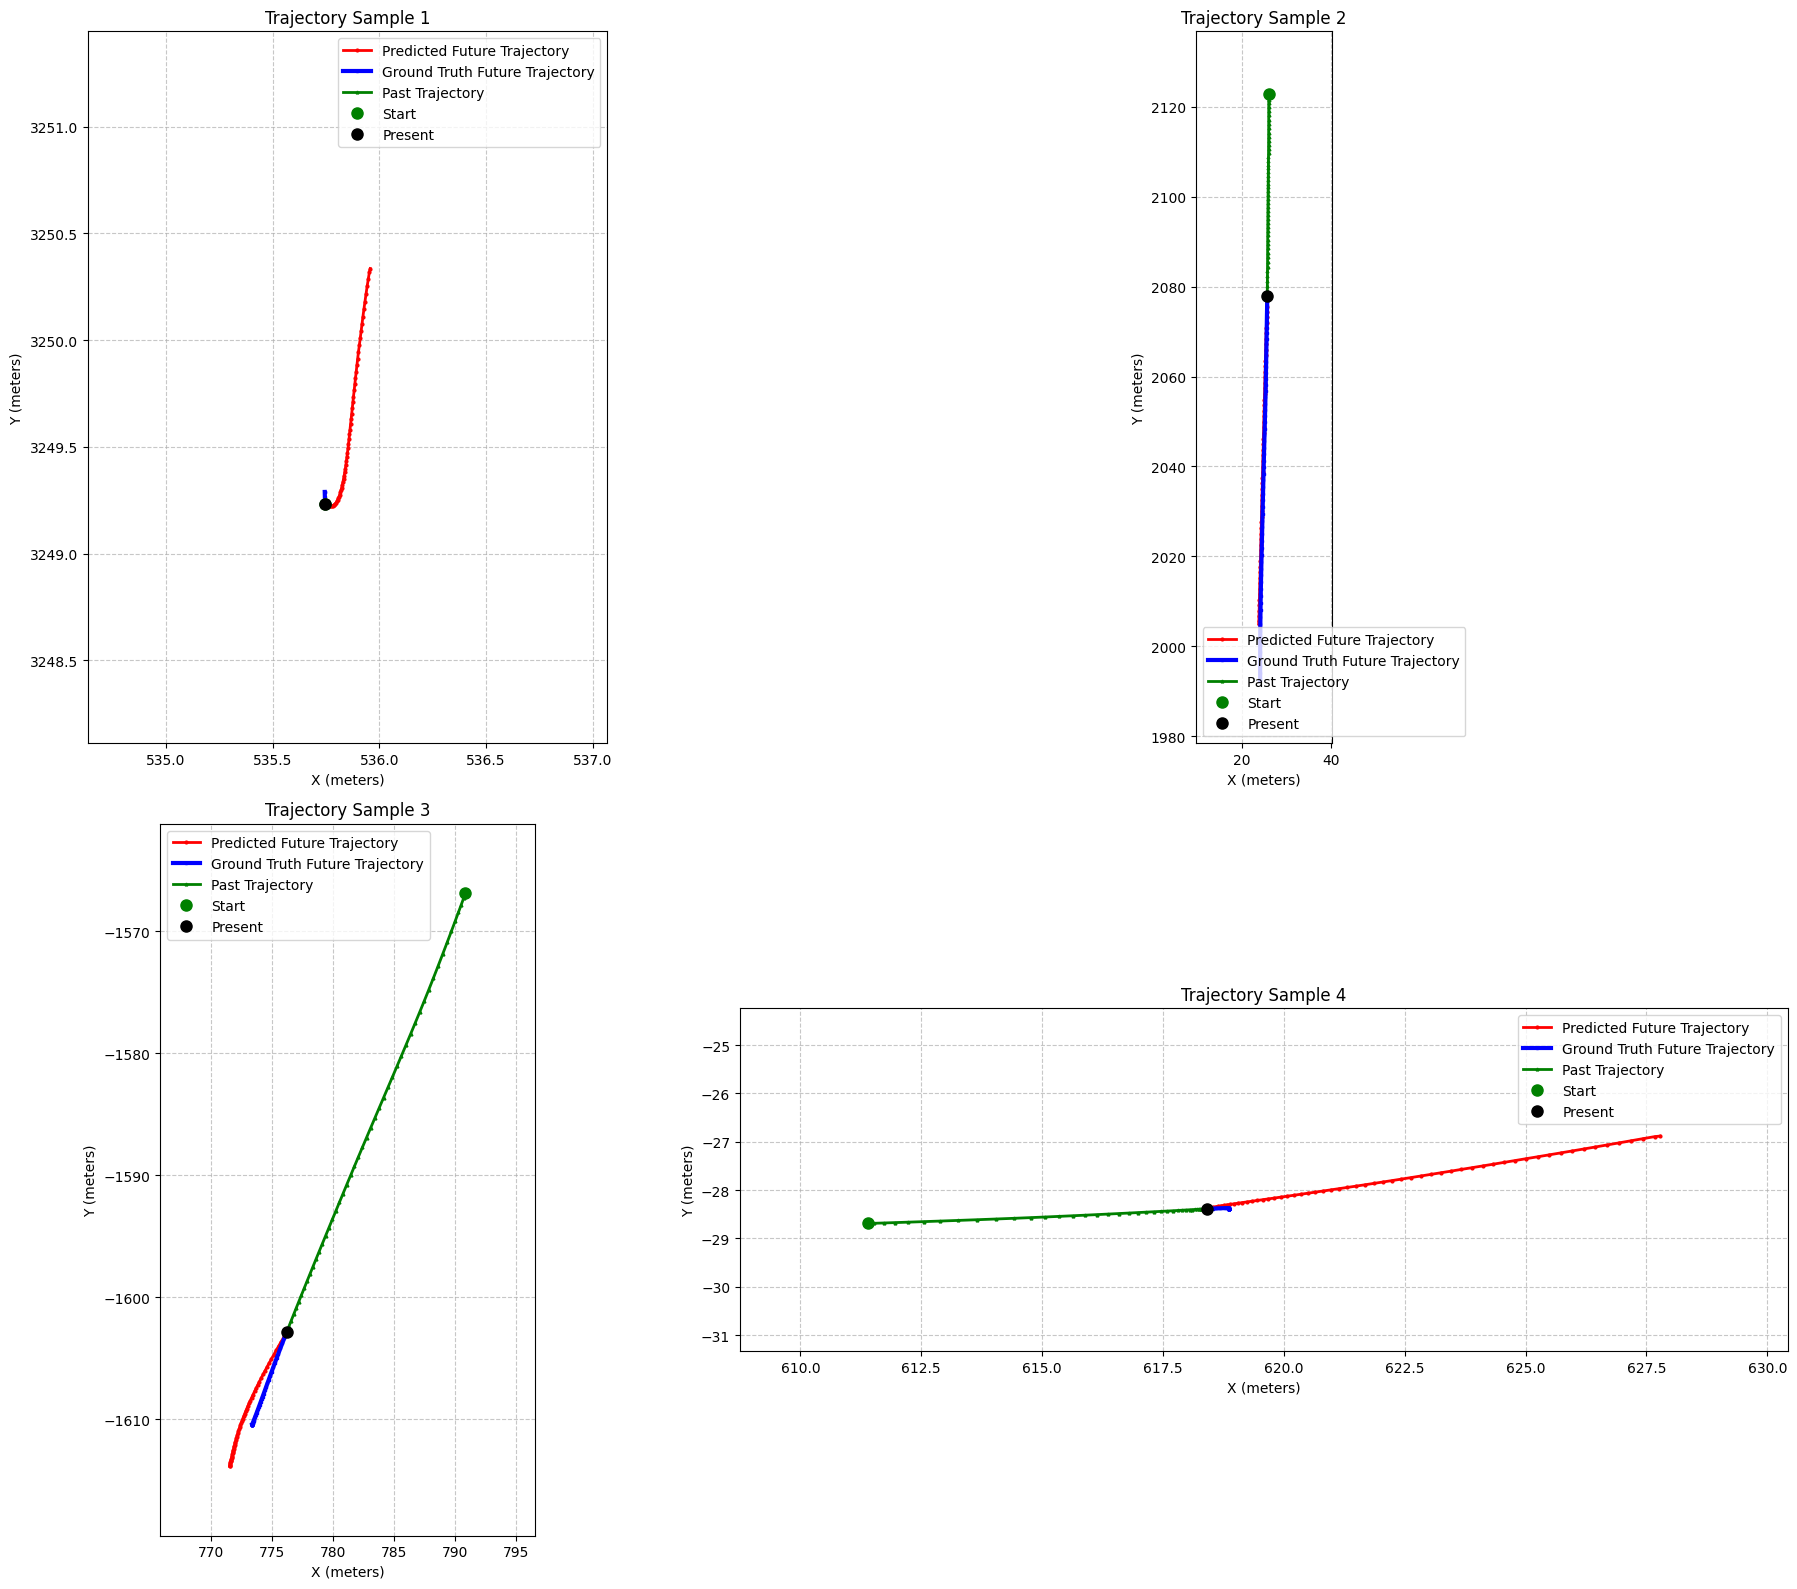


Sample 0 debugging:
Past trajectory first 5 points:
[[ 535.7463 3249.2341]
 [ 535.7463 3249.2341]
 [ 535.7463 3249.2341]
 [ 535.7463 3249.2341]
 [ 535.7463 3249.2341]]
Past trajectory last 5 points:
[[ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]]
Predicted trajectory first 5 points:
[[ 535.75116 3249.2307 ]
 [ 535.756   3249.228  ]
 [ 535.7607  3249.2258 ]
 [ 535.76514 3249.224  ]
 [ 535.76953 3249.2231 ]]
GT trajectory first 5 points:
[[ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]]


In [99]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# ---- Load Model ----
best_model2 = torch.load(best_model)
model = SimpleLSTM().to(device)
model.load_state_dict(best_model2)
model.eval()

# ---- Plotting Function ----
def plot_trajectory(ax, past, pred, gt, title=None):
    ax.cla()
    
    # Plot trajectories
    ax.plot(pred[:, 0], pred[:, 1], color='red', label='Predicted Future Trajectory', linewidth=2, marker='o', markersize=2)
    ax.plot(gt[:, 0], gt[:, 1], color='blue', label='Ground Truth Future Trajectory', linewidth=3, marker='s', markersize=2)
    ax.plot(past[:, 0], past[:, 1], color='green', label='Past Trajectory', linewidth=2, marker='^', markersize=2)
    
    # Mark start and end points
    ax.plot(past[0, 0], past[0, 1], 'go', markersize=8, label='Start')
    ax.plot(past[-1, 0], past[-1, 1], 'ko', markersize=8, label='Present')
    
    # Set axis limits with some padding
    all_x = np.concatenate([past[:, 0], pred[:, 0], gt[:, 0]])
    all_y = np.concatenate([past[:, 1], pred[:, 1], gt[:, 1]])
    
    x_range = all_x.max() - all_x.min()
    y_range = all_y.max() - all_y.min()
    padding = max(x_range, y_range) * 0.1 + 1  # Add some padding
    
    ax.set_xlim(all_x.min() - padding, all_x.max() + padding)
    ax.set_ylim(all_y.min() - padding, all_y.max() + padding)
    
    ax.set_xlabel('X (meters)')
    ax.set_ylabel('Y (meters)')
    if title:
        ax.set_title(title)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_aspect('equal', adjustable='box')

# ---- Inference + Collection ----
samples = []
dt = 0.1

with torch.no_grad():
    for b, batch in enumerate(val_dataloader):
        if b in [0, 1]:
            continue  # Skip the first batch
    
        if len(samples) >= 4:
            break
            
        batch = batch.to(device)
        scale = batch.scale.view(-1, 1, 1).cpu().numpy()  # (B, 1, 1)
        origin = batch.origin.cpu().numpy()  # This might be (B, 2) instead of (B, 1, 2)
        
        # Debug: Print actual shapes
        print(f'Batch {b}: origin shape: {origin.shape}, scale shape: {scale.shape}')
        print(f'Origin array:\n{origin}')
        print(f'Scale array:\n{scale}')
        
        # Get predictions
        gt_vel = batch.y.view(batch.num_graphs, 60, 2) * batch.scale.view(-1, 1, 1)  # (B, 60, 2)
        pred_vel = model(batch) * batch.scale.view(-1, 1, 1)  # (B, 60, 2)
        
        # Convert to CPU numpy
        gt_vel = gt_vel.cpu().numpy()
        pred_vel = pred_vel.cpu().numpy()
        
        for i in range(batch.num_graphs):
            if len(samples) >= 4:
                break
                
            # Extract data for this sample - FIXED INDEXING
            current_scale = scale[i, 0, 0]  # scalar
            
            # Fix the origin indexing based on actual shape
            if len(origin.shape) == 3:  # (B, 1, 2)
                current_origin = origin[i, 0, :]  # (2,)
            elif len(origin.shape) == 2:  # (B, 2)
                current_origin = origin[i, :]  # (2,)
            else:
                print(f"Unexpected origin shape: {origin.shape}")
                continue
            
            print(f'Sample {i}: origin={current_origin}, scale={current_scale}')
            
            # Get past trajectory for ego agent (agent 0)
            # batch.x shape: (total_nodes, 50, 5) where 5 = [x, y, vx, vy, heading]
            # We need to extract the ego agent's trajectory for sample i
            
            # Calculate node indices for sample i
            start_idx = i * 50  # Assuming 50 agents per scene
            end_idx = start_idx + 50
            
            ego_idx = start_idx  # Ego agent is the first agent in each scene
            past_trajectory = batch.x[ego_idx, :, :2].cpu().numpy()  # (50, 2) - positions only
            
            # Denormalize past trajectory
            past_trajectory = past_trajectory * current_scale + current_origin
            
            print(f'scene: {i}')
            print(f'past_trajectory: {past_trajectory}')
            
            # Get velocities for future prediction
            pred_vel_sample = pred_vel[i]  # (60, 2)
            gt_vel_sample = gt_vel[i]    # (60, 2)
            
            print(f'Past trajectory shape: {past_trajectory.shape}')
            print(f'Past trajectory range: x=[{past_trajectory[:, 0].min():.1f}, {past_trajectory[:, 0].max():.1f}], y=[{past_trajectory[:, 1].min():.1f}, {past_trajectory[:, 1].max():.1f}]')
            
            # Integrate future positions from velocities
            # Start from the last position of past trajectory
            last_pos = past_trajectory[-1]  # (2,)
            
            # Predicted future positions
            pred_positions = [last_pos.copy()]
            for t in range(60):
                next_pos = pred_positions[-1] + pred_vel_sample[t] * dt
                pred_positions.append(next_pos)
            pred_positions = np.array(pred_positions[1:])  # Remove initial position, keep 60 future positions
            
            # Ground truth future positions
            gt_positions = [last_pos.copy()]
            for t in range(60):
                next_pos = gt_positions[-1] + gt_vel_sample[t] * dt
                gt_positions.append(next_pos)
            gt_positions = np.array(gt_positions[1:])  # Remove initial position, keep 60 future positions
            
            print(f'Pred positions shape: {pred_positions.shape}')
            print(f'GT positions shape: {gt_positions.shape}')
            print(f'Pred positions range: x=[{pred_positions[:, 0].min():.1f}, {pred_positions[:, 0].max():.1f}], y=[{pred_positions[:, 1].min():.1f}, {pred_positions[:, 1].max():.1f}]')
            
            # Store sample
            samples.append({
                'past': past_trajectory,
                'pred': pred_positions,
                'gt': gt_positions,
            })
            
            print(f'Added sample {len(samples)}, total samples: {len(samples)}')

print(f'\nCollected {len(samples)} samples')
if len(samples) > 0:
    print(f'Sample 0 shapes: past={samples[0]["past"].shape}, pred={samples[0]["pred"].shape}, gt={samples[0]["gt"].shape}')

# ---- Plot ----
if len(samples) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()
    
    plot_samples = samples[:4] if len(samples) >= 4 else samples
    
    for i, sample in enumerate(plot_samples):
        print(f'Plotting sample {i}')
        print(f'  Past range: x=[{sample["past"][:, 0].min():.1f}, {sample["past"][:, 0].max():.1f}], y=[{sample["past"][:, 1].min():.1f}, {sample["past"][:, 1].max():.1f}]')
        print(f'  Pred range: x=[{sample["pred"][:, 0].min():.1f}, {sample["pred"][:, 0].max():.1f}], y=[{sample["pred"][:, 1].min():.1f}, {sample["pred"][:, 1].max():.1f}]')
        print(f'  GT range: x=[{sample["gt"][:, 0].min():.1f}, {sample["gt"][:, 0].max():.1f}], y=[{sample["gt"][:, 1].min():.1f}, {sample["gt"][:, 1].max():.1f}]')
        
        plot_trajectory(axes[i], sample['past'], sample['pred'], sample['gt'], title=f"Trajectory Sample {i+1}")
    
    # Hide unused subplots
    for i in range(len(plot_samples), 4):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("No samples collected - check your data processing!")

# Additional debugging: Print some sample values
if len(samples) > 0:
    sample = samples[0]
    print(f"\nSample 0 debugging:")
    print(f"Past trajectory first 5 points:\n{sample['past'][:5]}")
    print(f"Past trajectory last 5 points:\n{sample['past'][-5:]}")
    print(f"Predicted trajectory first 5 points:\n{sample['pred'][:5]}")
    print(f"GT trajectory first 5 points:\n{sample['gt'][:5]}")

# Additional debugging function to understand your data structure better
def debug_batch_structure(batch):
    """Helper function to understand the batch structure"""
    print("\n=== BATCH STRUCTURE DEBUG ===")
    print(f"batch.num_graphs: {batch.num_graphs}")
    print(f"batch.x.shape: {batch.x.shape}")
    print(f"batch.y.shape: {batch.y.shape}")
    print(f"batch.scale.shape: {batch.scale.shape}")
    print(f"batch.origin.shape: {batch.origin.shape}")
    
    if hasattr(batch, 'batch'):
        print(f"batch.batch.shape: {batch.batch.shape}")
        print(f"batch.batch unique values: {torch.unique(batch.batch)}")
    
    print("Origin values:")
    print(batch.origin.cpu().numpy())
    print("Scale values:")
    print(batch.scale.cpu().numpy())
    print("===============================\n")

# Uncomment the line below to run the debug function on your first batch
# debug_batch_structure(next(iter(val_dataloader)).to(device))

Batch 2: origin shape: (32, 2), scale shape: (32, 1, 1)
Origin array:
[[  535.74615   3249.2341  ]
 [   25.715364  2077.918   ]
 [  776.16876  -1602.885   ]
 [  618.4111     -28.385862]
 [11756.716     5224.448   ]
 [  -99.0203    -205.09248 ]
 [ 5589.5454    2166.4856  ]
 [  576.5858    1281.5502  ]
 [  346.50455  -1478.2499  ]
 [ 3747.403    -2031.8069  ]
 [ 2759.4443   -1484.7734  ]
 [ 5432.695     1797.2394  ]
 [-1447.3081    1800.8248  ]
 [ 9846.43      3277.9082  ]
 [ 5581.5996     752.5961  ]
 [ 9993.361     5121.5425  ]
 [ -814.305    -2415.3994  ]
 [ 4804.9727    3348.715   ]
 [   50.00897   -679.9272  ]
 [  163.55113   -148.68156 ]
 [ 6340.244     -137.16518 ]
 [  641.7041    -908.7565  ]
 [ 7986.2783    3285.629   ]
 [ -812.3995   -1081.4679  ]
 [  326.5171    -879.4236  ]
 [  382.07574    816.5598  ]
 [  712.54254  -1604.3905  ]
 [ 6587.951     1235.543   ]
 [ -426.26453    405.36816 ]
 [ 6470.7017    1761.914   ]
 [ 4183.4834    2726.129   ]
 [  693.46783   1000.6648  ]]
S

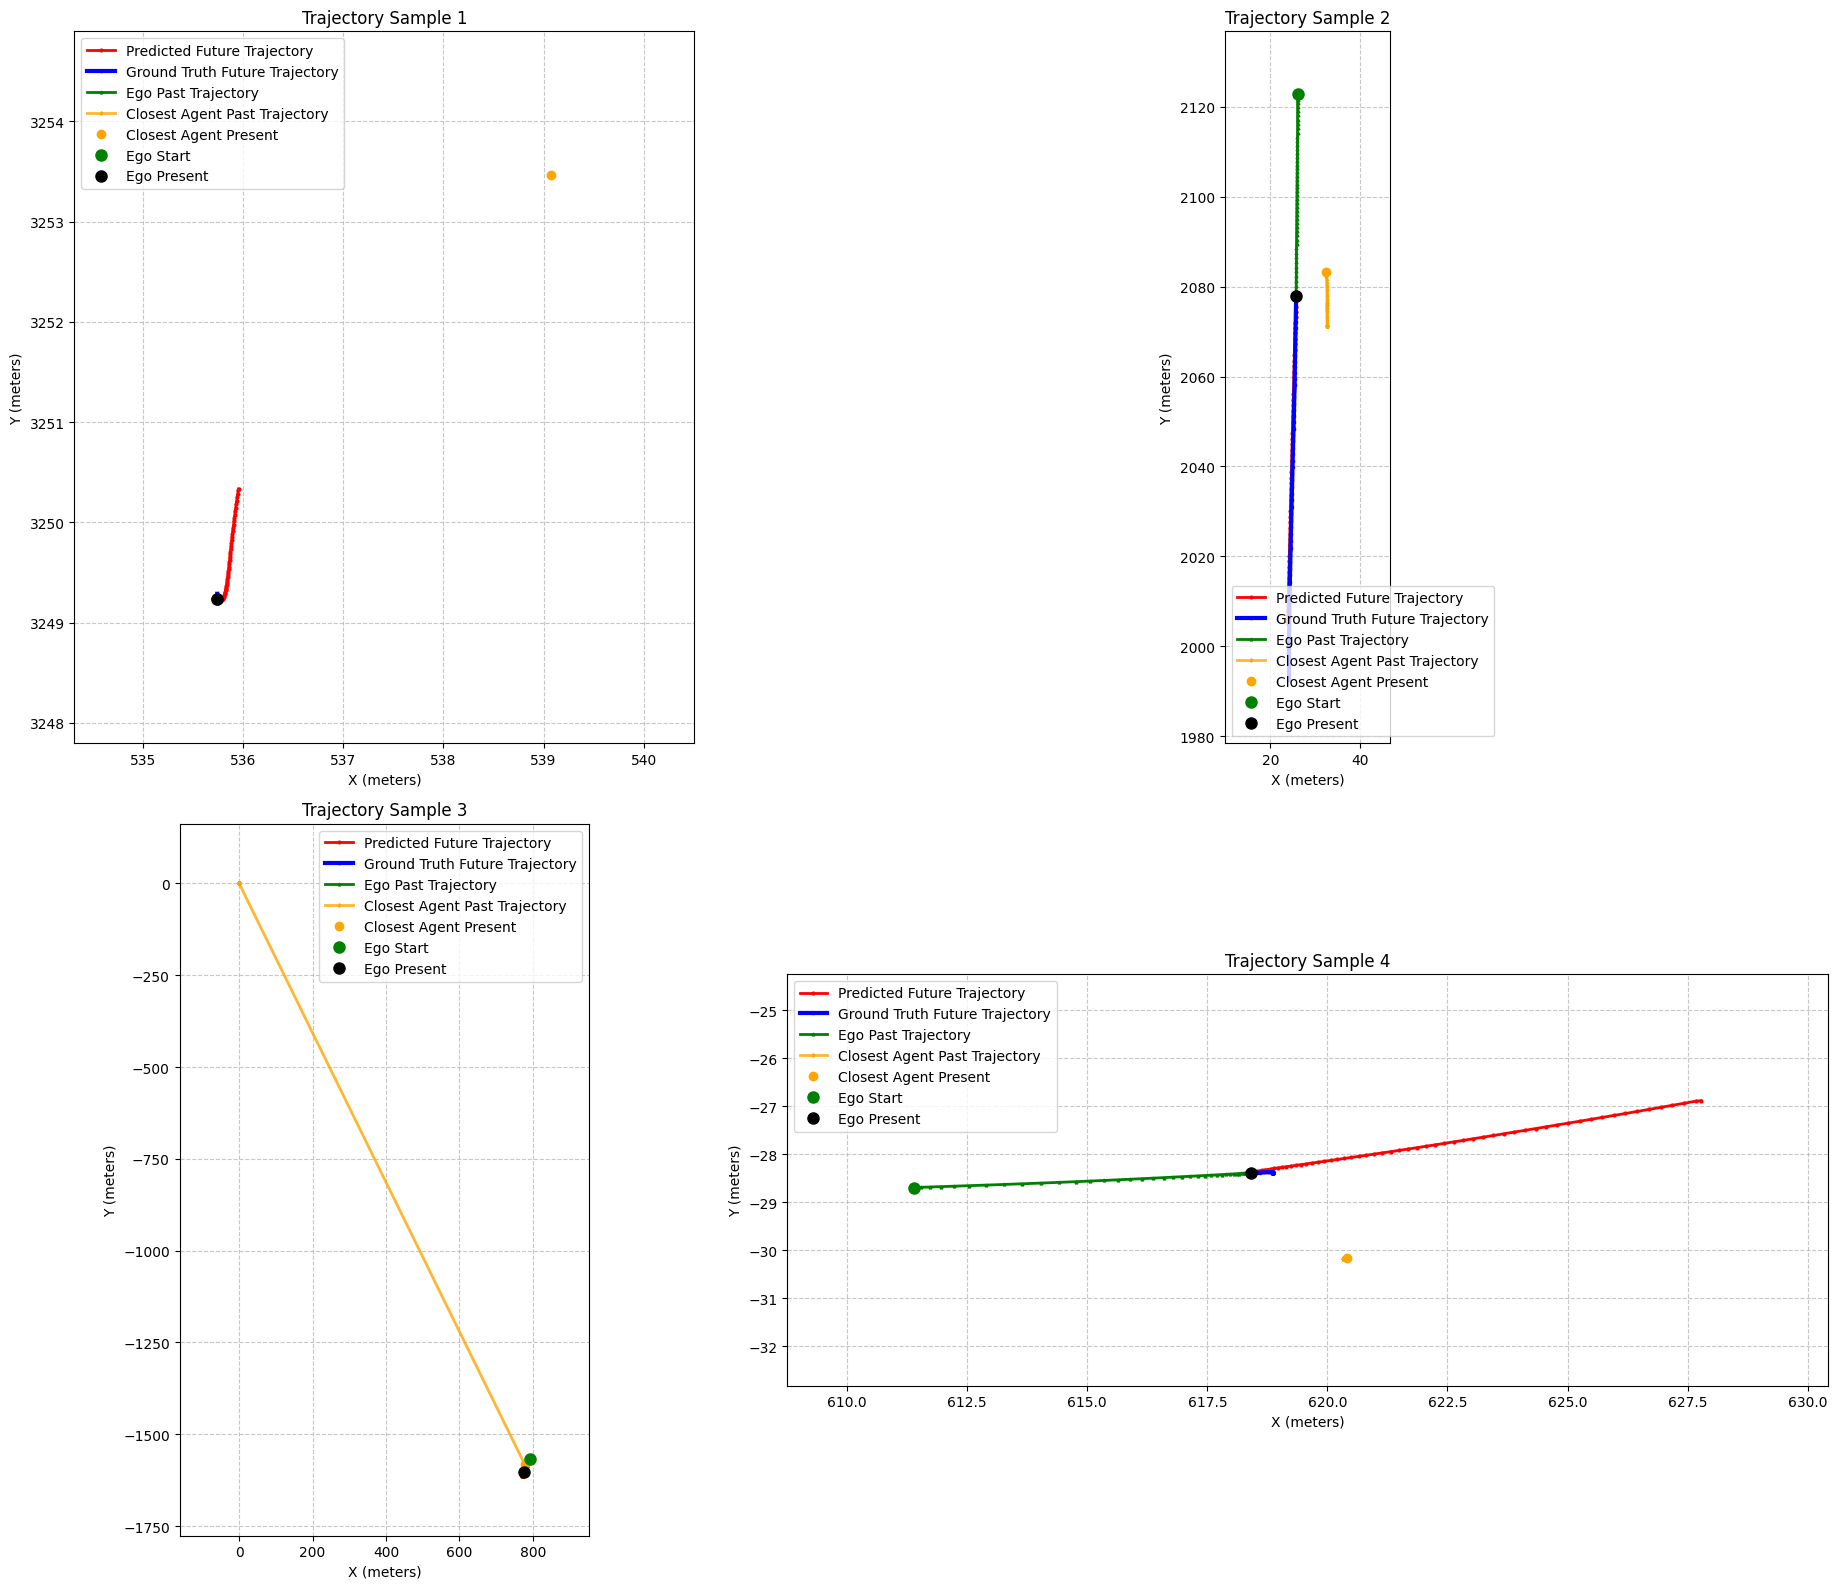


Sample 0 debugging:
Past trajectory first 5 points:
[[ 535.7463 3249.2341]
 [ 535.7463 3249.2341]
 [ 535.7463 3249.2341]
 [ 535.7463 3249.2341]
 [ 535.7463 3249.2341]]
Past trajectory last 5 points:
[[ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]]
Predicted trajectory first 5 points:
[[ 535.75116 3249.2307 ]
 [ 535.756   3249.228  ]
 [ 535.7607  3249.2258 ]
 [ 535.76514 3249.224  ]
 [ 535.76953 3249.2231 ]]
GT trajectory first 5 points:
[[ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]]


In [100]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# ---- Load Model ----
best_model2 = torch.load(best_model)
model = SimpleLSTM().to(device)
model.load_state_dict(best_model2)
model.eval()

# ---- Plotting Function ----
def plot_trajectory(ax, past, pred, gt, closest_agent_past=None, title=None):
    ax.cla()
    
    # Plot trajectories
    ax.plot(pred[:, 0], pred[:, 1], color='red', label='Predicted Future Trajectory', linewidth=2, marker='o', markersize=2)
    ax.plot(gt[:, 0], gt[:, 1], color='blue', label='Ground Truth Future Trajectory', linewidth=3, marker='s', markersize=2)
    ax.plot(past[:, 0], past[:, 1], color='green', label='Ego Past Trajectory', linewidth=2, marker='^', markersize=2)
    
    # Plot closest agent trajectory if provided
    if closest_agent_past is not None:
        ax.plot(closest_agent_past[:, 0], closest_agent_past[:, 1], color='orange', label='Closest Agent Past Trajectory', 
                linewidth=2, marker='d', markersize=2, alpha=0.8)
        # Mark closest agent's final position
        ax.plot(closest_agent_past[-1, 0], closest_agent_past[-1, 1], 'o', color='orange', markersize=6, label='Closest Agent Present')
    
    # Mark start and end points for ego
    ax.plot(past[0, 0], past[0, 1], 'go', markersize=8, label='Ego Start')
    ax.plot(past[-1, 0], past[-1, 1], 'ko', markersize=8, label='Ego Present')
    
    # Set axis limits with some padding
    all_x = np.concatenate([past[:, 0], pred[:, 0], gt[:, 0]])
    all_y = np.concatenate([past[:, 1], pred[:, 1], gt[:, 1]])
    
    # Include closest agent in axis calculations if available
    if closest_agent_past is not None:
        all_x = np.concatenate([all_x, closest_agent_past[:, 0]])
        all_y = np.concatenate([all_y, closest_agent_past[:, 1]])
    
    x_range = all_x.max() - all_x.min()
    y_range = all_y.max() - all_y.min()
    padding = max(x_range, y_range) * 0.1 + 1  # Add some padding
    
    ax.set_xlim(all_x.min() - padding, all_x.max() + padding)
    ax.set_ylim(all_y.min() - padding, all_y.max() + padding)
    
    ax.set_xlabel('X (meters)')
    ax.set_ylabel('Y (meters)')
    if title:
        ax.set_title(title)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_aspect('equal', adjustable='box')

# ---- Inference + Collection ----
samples = []
dt = 0.1

with torch.no_grad():
    for b, batch in enumerate(val_dataloader):
        if b in [0, 1]:
            continue  # Skip the first batch
        if len(samples) >= 4:
            break
            
        batch = batch.to(device)
        scale = batch.scale.view(-1, 1, 1).cpu().numpy()  # (B, 1, 1)
        origin = batch.origin.cpu().numpy()  # This might be (B, 2) instead of (B, 1, 2)
        
        # Debug: Print actual shapes
        print(f'Batch {b}: origin shape: {origin.shape}, scale shape: {scale.shape}')
        print(f'Origin array:\n{origin}')
        print(f'Scale array:\n{scale}')
        
        # Get predictions
        gt_vel = batch.y.view(batch.num_graphs, 60, 2) * batch.scale.view(-1, 1, 1)  # (B, 60, 2)
        pred_vel = model(batch) * batch.scale.view(-1, 1, 1)  # (B, 60, 2)
        
        # Convert to CPU numpy
        gt_vel = gt_vel.cpu().numpy()
        pred_vel = pred_vel.cpu().numpy()
        
        for i in range(batch.num_graphs):
            if len(samples) >= 4:
                break
                
            # Extract data for this sample - FIXED INDEXING
            current_scale = scale[i, 0, 0]  # scalar
            
            # Fix the origin indexing based on actual shape
            if len(origin.shape) == 3:  # (B, 1, 2)
                current_origin = origin[i, 0, :]  # (2,)
            elif len(origin.shape) == 2:  # (B, 2)
                current_origin = origin[i, :]  # (2,)
            else:
                print(f"Unexpected origin shape: {origin.shape}")
                continue
            
            print(f'Sample {i}: origin={current_origin}, scale={current_scale}')
            
            # Get past trajectory for ego agent (agent 0)
            # batch.x shape: (total_nodes, 50, 5) where 5 = [x, y, vx, vy, heading]
            # We need to extract the ego agent's trajectory for sample i
            
            # Calculate node indices for sample i
            start_idx = i * 50  # Assuming 50 agents per scene
            end_idx = start_idx + 50
            
            ego_idx = start_idx  # Ego agent is the first agent in each scene
            past_trajectory = batch.x[ego_idx, :, :2].cpu().numpy()  # (50, 2) - positions only
            
            # Denormalize past trajectory
            past_trajectory = past_trajectory * current_scale + current_origin
            
            # Find closest agent at the 50th timestep (last timestep)
            ego_final_pos = past_trajectory[-1]  # Position at timestep 50
            closest_agent_idx = None
            min_distance = float('inf')
            
            # Check all other agents in this scene
            for agent_idx in range(start_idx + 1, end_idx):  # Skip ego agent (start_idx)
                if agent_idx < batch.x.shape[0]:  # Make sure we don't go out of bounds
                    agent_final_pos = batch.x[agent_idx, -1, :2].cpu().numpy()  # Last timestep position
                    agent_final_pos = agent_final_pos * current_scale + current_origin  # Denormalize
                    
                    # Calculate distance to ego at final timestep
                    distance = np.linalg.norm(ego_final_pos - agent_final_pos)
                    if distance < min_distance:
                        min_distance = distance
                        closest_agent_idx = agent_idx
            
            # Get closest agent's past trajectory
            closest_agent_past = None
            if closest_agent_idx is not None:
                closest_agent_past = batch.x[closest_agent_idx, :, :2].cpu().numpy()  # (50, 2)
                closest_agent_past = closest_agent_past * current_scale + current_origin  # Denormalize
                print(f'Closest agent distance: {min_distance:.2f}m at final timestep')
            else:
                print('No closest agent found')
            
            # Get velocities for future prediction
            pred_vel_sample = pred_vel[i]  # (60, 2)
            gt_vel_sample = gt_vel[i]    # (60, 2)
            
            print(f'Past trajectory shape: {past_trajectory.shape}')
            print(f'Past trajectory range: x=[{past_trajectory[:, 0].min():.1f}, {past_trajectory[:, 0].max():.1f}], y=[{past_trajectory[:, 1].min():.1f}, {past_trajectory[:, 1].max():.1f}]')
            
            # Integrate future positions from velocities
            # Start from the last position of past trajectory
            last_pos = past_trajectory[-1]  # (2,)
            
            # Predicted future positions
            pred_positions = [last_pos.copy()]
            for t in range(60):
                next_pos = pred_positions[-1] + pred_vel_sample[t] * dt
                pred_positions.append(next_pos)
            pred_positions = np.array(pred_positions[1:])  # Remove initial position, keep 60 future positions
            
            # Ground truth future positions
            gt_positions = [last_pos.copy()]
            for t in range(60):
                next_pos = gt_positions[-1] + gt_vel_sample[t] * dt
                gt_positions.append(next_pos)
            gt_positions = np.array(gt_positions[1:])  # Remove initial position, keep 60 future positions
            
            print(f'Pred positions shape: {pred_positions.shape}')
            print(f'GT positions shape: {gt_positions.shape}')
            print(f'Pred positions range: x=[{pred_positions[:, 0].min():.1f}, {pred_positions[:, 0].max():.1f}], y=[{pred_positions[:, 1].min():.1f}, {pred_positions[:, 1].max():.1f}]')
            
            # Store sample
            samples.append({
                'past': past_trajectory,
                'pred': pred_positions,
                'gt': gt_positions,
                'closest_agent_past': closest_agent_past,
            })
            
            print(f'Added sample {len(samples)}, total samples: {len(samples)}')

print(f'\nCollected {len(samples)} samples')
if len(samples) > 0:
    print(f'Sample 0 shapes: past={samples[0]["past"].shape}, pred={samples[0]["pred"].shape}, gt={samples[0]["gt"].shape}')

# ---- Plot ----
if len(samples) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()
    
    plot_samples = samples[:4] if len(samples) >= 4 else samples
    
    for i, sample in enumerate(plot_samples):
        print(f'Plotting sample {i}')
        print(f'  Past range: x=[{sample["past"][:, 0].min():.1f}, {sample["past"][:, 0].max():.1f}], y=[{sample["past"][:, 1].min():.1f}, {sample["past"][:, 1].max():.1f}]')
        print(f'  Pred range: x=[{sample["pred"][:, 0].min():.1f}, {sample["pred"][:, 0].max():.1f}], y=[{sample["pred"][:, 1].min():.1f}, {sample["pred"][:, 1].max():.1f}]')
        print(f'  GT range: x=[{sample["gt"][:, 0].min():.1f}, {sample["gt"][:, 0].max():.1f}], y=[{sample["gt"][:, 1].min():.1f}, {sample["gt"][:, 1].max():.1f}]')
        
        plot_trajectory(axes[i], sample['past'], sample['pred'], sample['gt'], 
                       closest_agent_past=sample['closest_agent_past'], 
                       title=f"Trajectory Sample {i+1}")
    
    # Hide unused subplots
    for i in range(len(plot_samples), 4):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("No samples collected - check your data processing!")

# Additional debugging: Print some sample values
if len(samples) > 0:
    sample = samples[0]
    print(f"\nSample 0 debugging:")
    print(f"Past trajectory first 5 points:\n{sample['past'][:5]}")
    print(f"Past trajectory last 5 points:\n{sample['past'][-5:]}")
    print(f"Predicted trajectory first 5 points:\n{sample['pred'][:5]}")
    print(f"GT trajectory first 5 points:\n{sample['gt'][:5]}")

# Additional debugging function to understand your data structure better
def debug_batch_structure(batch):
    """Helper function to understand the batch structure"""
    print("\n=== BATCH STRUCTURE DEBUG ===")
    print(f"batch.num_graphs: {batch.num_graphs}")
    print(f"batch.x.shape: {batch.x.shape}")
    print(f"batch.y.shape: {batch.y.shape}")
    print(f"batch.scale.shape: {batch.scale.shape}")
    print(f"batch.origin.shape: {batch.origin.shape}")
    
    if hasattr(batch, 'batch'):
        print(f"batch.batch.shape: {batch.batch.shape}")
        print(f"batch.batch unique values: {torch.unique(batch.batch)}")
    
    print("Origin values:")
    print(batch.origin.cpu().numpy())
    print("Scale values:")
    print(batch.scale.cpu().numpy())
    print("===============================\n")

# Uncomment the line below to run the debug function on your first batch
# debug_batch_structure(next(iter(val_dataloader)).to(device))

# Final Pred

In [65]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model2 = torch.load(best_model)
model = SimpleLSTM().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
# criterion = nn.MSELoss()

model.load_state_dict(best_model2)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_vel_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred_vel = pred_vel_norm * batch.scale.view(-1,1,1)
        
        # Get origin in meters (position at t=49 for ego)
        # origin = batch.origin  # (B, 1, 2)
        origin = batch.origin.unsqueeze(1)  # Ensure shape is (B, 1, 2)
        
        # Integrate velocity to get position over 60 steps
        dt = 0.1  # seconds per step
        pred_pos = [origin]  # list of (B, 1, 2)
        
        for t in range(60):
            next_pos = pred_pos[-1] + pred_vel[:, t:t+1, :] * dt  # (B, 1, 2)
            pred_pos.append(next_pos)
        
        # Concatenate positions across time steps
        pred_xy = torch.cat(pred_pos[1:], dim=1)  # skip initial origin, get (B, 60, 2)

        pred_list.append(pred_xy.cpu().numpy())
        
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission_lstm_simple_auto8_axayangvel.csv', index=True)
# output_df.to_csv('submission_lstm_simple_auto8_largerhidden.csv', index=True)